# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

//anaconda/envs/cv/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
//anaconda/envs/cv/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


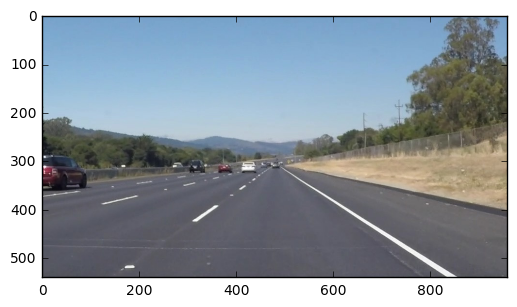

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [299]:
import math

m_size = 32  # the window for our moving average
left_mem = [] # our history of values for the left marker
right_mem = [] # our history of values for the right marker

def init():
    # i know, globals suck.
    # here we zero out our memory for the moving average caculation
    global m_size, left_mem, right_mem
    left_mem = []
    right_mem = []
    
def remember(left, right):
    # we store a new pair of left, right markers in our left, right memory.
    # we also clean up memory until we're back to the new "m_size" limit.
    global m_size, left_mem, right_mem
    left_mem.append(left)
    right_mem.append(right)
    while len(left_mem) > m_size:
        left_mem = left_mem[1:]
        right_mem = right_mem[1:]
        
def sma(hist):
    # a simple moving average for (m,b) models for a lane marker
    return np.mean(hist, axis=0)

def process(img):
    # here's the basic pipeline for a single frame
    #
    # First, line up all our parameters
    #
    xsize = img.shape[1]
    ysize = img.shape[0]
    dx = int(xsize*0.05) # offset from x left, right border
    dy = int(ysize*0.56) # offset from y top border
    center = int(0.5*xsize) 
    vertices = np.array([[(dx,ysize), (center-2, dy), (center+2,dy), (xsize-dx, ysize)]], dtype=np.int32)
    kernel = 5  # gaussian blur kernel size
    lo_threshold = 50 # low threshold for canny edge filter
    hi_threshold = 150 # high threshold for canny
    rho = 1 # grid increment for rho in rho, theta space 
    theta = np.pi/180 # grid increment for theta in rho, theta space
    threshold = 3 # number of items passing through a grid cell to be a line
    min_line_length = 8 # smallest line we'll accept
    max_line_gap = 3 # maximum distance between lines
    
    # Now churn through the steps and return an image with overlays for markers
    #
    out = grayscale(img)
    out = gaussian_blur(out, kernel)
    out = canny(out, lo_threshold, hi_threshold)
    out = region_of_interest(out, vertices)
    out = hough_lines(out, rho, theta, threshold, min_line_length, max_line_gap)
    return weighted_img(out, img)

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color  
    #print(vertices, ignore_mask_color)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def weighted_mean(vals):
    # weight the (m,b) of a line by its length in a set of line segments,
    # then return the weighted average for the set.
    d = 1.0/np.sum(x[2] for x in vals)
    m = d*np.sum(x[0]*x[2] for x in vals)
    b = d*np.sum(x[1]*x[2] for x in vals)
    return (m, b)

def is_right(slope,x1,x2,width):
    # A right marker will be 25' to 75' degrees and on the right of center
    min_tan = math.tan(25*np.pi/180.0)
    max_tan = math.tan(75*np.pi/180.0)
    min_x = width*0.6
    return (x1 > min_x) and (x2 > min_x) and (slope >= min_tan) and (slope <= max_tan)

def is_left(slope,x1,x2,width):
    # A left marker will be 105' to 155' degrees and on the left of center
    min_tan = math.tan(105*np.pi/180.0)
    max_tan = math.tan(155*np.pi/180.0)
    max_x = width*0.4
    return (x1 < max_x) and (x2 < max_x) and (slope >= min_tan) and (slope <= max_tan)

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    global left_mem, right_mem
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    left = []
    right = []
    height = img.shape[0]
    width = img.shape[1]
    #
    # Separate little lines into left & right buckets
    #
    for line in lines:
        for x1,y1,x2,y2 in line:
            if x1 != x2:
                m = (y2-y1)/(x2-x1)
                b = y2 - m*x2
                d = math.sqrt((y2-y1)**2 + (x2-x1)**2)
                if d > 4:
                    if is_left(m,x1,x2,width):
                        left.append((m,b,d))
                    elif is_right(m,x1,x2,width):
                        right.append((m,b,d))
    #
    # If we have buckets on both sides, add them to memory
    #
    if (len(left) > 0) and (len(right) > 0):
        #
        # Turn each bucket into a weighted average of the lines,
        # where lines vote by their length.
        #
        remember(weighted_mean(left),weighted_mean(right))
    
    #
    # Calculate our true lines through a simple moving average
    # of previous left and right line marker values.  This will
    # change less frequently and better characterize lanes as
    # we see shadows, poor markings, and what not. 
    #
    ys = img.shape[0]
    for m, b in [sma(left_mem), sma(right_mem)]:
        y0 = ys
        x0 = int((y0-b)*1.0/m)
        y1 = int(ys*0.6)
        x1 = int((y1-b)*1.0/m)
        cv2.line(img, (x0, y0), (x1, y1), [255,0,0], 4)
    return 

    # Keep this around for debugging, showing us all the little red lines
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    color_edges = np.dstack((lines, lines, lines)) 
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, a=0.8, b=1., g=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, a, img, b, g)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

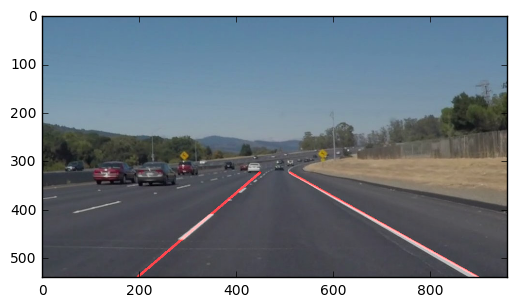

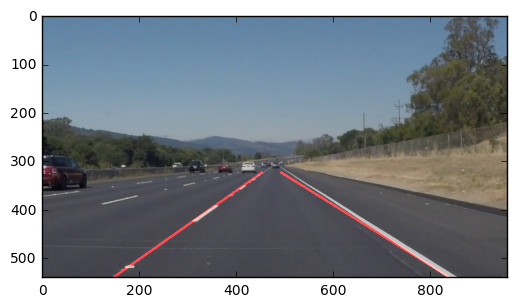

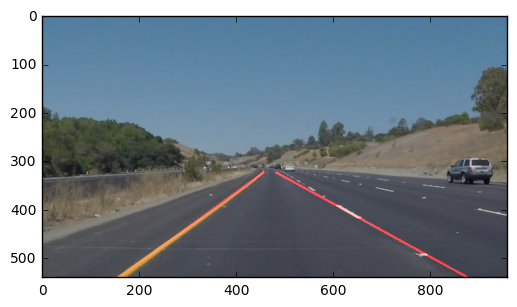

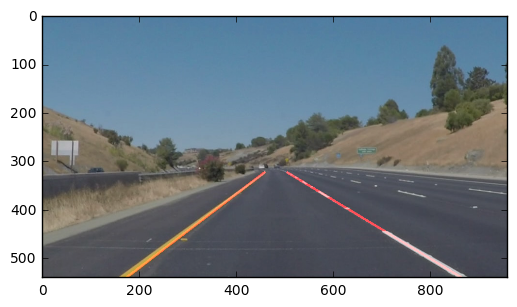

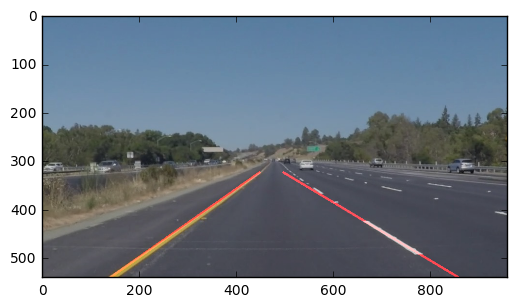

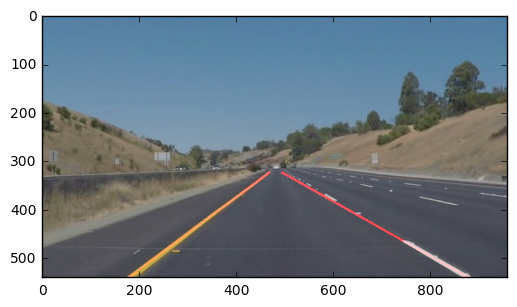

In [300]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

base = "test_images/"
for fig, f in enumerate(os.listdir(base)):
    init()
    plt.figure(fig)
    plt.imshow(process(mpimg.imread(base+f).astype('uint8')))

plt.show()

run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [301]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [167]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    return process(image)

Let's try the one with the solid white lane on the right first ...

In [302]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
init()
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

  self.nchannels))



[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:05<00:00, 38.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 2.89 s, sys: 882 ms, total: 3.78 s
Wall time: 6.53 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [303]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [304]:
yellow_output = 'yellow.mp4'
init()
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

  self.nchannels))



[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:21<00:00, 18.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 9.34 s, sys: 3.3 s, total: 12.6 s
Wall time: 22.8 s


In [296]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

## Thoughts

I've created a 5-stage pipeline, inspired by the previous lessons.  First, I convert an image frame to grayscale.  Next, I soften the image a bit with a gaussian blur with a 7x7 kernel to remove high frequency noise.  After this we apply a canny edge filter of [50,150].  I then snip out a triangular region on the lower half of the image, roughly 10% from the left and right and 55% from the top.  Finally, I use a hough transform to find lines in a fine-grained
grid of 1 degree and 1 pixel.

These give us candidate lines.  I separate the lines into two buckets, one for lines on the left hand side of the image that tilt right, and nother for lines on the right hand side that tilt left.  I then calculate a weighted average of both sets, where weights are proportional to the length of the line segment.  This tends to favor longer lines that are closer to the driver, and discount smaller lines that are farther away.  I then calculate a moving average of the last 32 line marker calculations, then plot the (m_sma, b_sma) values starting from the bottom of the window frame up to the middle of the frame.

My initial algorithm was subject to noise in the images caused by shadows, poor markings, low contrast.  Taking a lesson from stock traiding, I applied a simple moving average and chose a window size of 32.  That did the trick.  

The algorithm could be improved with better color correction, identifying the whites and yellows of an image and highlighting them before converting to grayscale.  Sustained exposure to high noise and poor markings will confuse the algorithm.  For that, we'll need better path planning and a way to extrapolate lines from one image to the next based on our direction of travel.  Sudden, sharp turns that fall outside our model for left and right markers will also confound us.


## Submission

If you're satisfied with your video outputs it's time to submit!


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [297]:
challenge_output = 'extra.mp4'
init()
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

  self.nchannels))



[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:17<00:00, 14.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 6.75 s, sys: 1.54 s, total: 8.29 s
Wall time: 19.7 s


In [298]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))